In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from collections import OrderedDict
from functools import partial
from random import shuffle
import matplotlib.pyplot as plt
import os
import re

#here are all the imports required to make our functions work

In [2]:
python vgg16.py

SyntaxError: invalid syntax (<ipython-input-2-efbd698de7ed>, line 1)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from collections import OrderedDict
from functools import partial
from random import shuffle
import matplotlib.pyplot as plt
import os
import re

In [ ]:
image_size = 224
input_shape = (1, image_size, image_size, 3)

# The VGG network requires the images to be zero mean
# This the mean value of the training data of the ImageNet 
# training set, which will be used to make images zero mean
vgg_mean = [123.68, 116.779, 103.939]

# Hyperparameters used to define the final loss
alpha = 1e3
beta = 1e-3

In [ ]:
def load_weights(weights_file, end_layer):
    """
    This function loads the weights_file and reads the weights until
    the end_layer is reached.
    """
    
    layers = OrderedDict()
    weights = np.load(weights_file)
    sorted_weights = sorted(weights.items())

    for i, (k, w) in enumerate(sorted_weights):
        # If we have loaded the correct number of layers we stop
        # to save memory
        if sum([1 if len(v)==2 else 0 for v in layers.values()]) >= end_layer:
            break
        
        if k[:-2] not in layers:
            layers[k[:-2]] = {}
            
        if re.search(r'conv\d+_\d+_W', k) is not None:
            layers[k[:-2]]['weights'] = w
            print()
        if re.search(r'conv\d+_\d+_b', k) is not None:
            layers[k[:-2]]['bias'] = w
  
        print('Loading the weights for the layer {} and shape {}'.format(k,w.shape))

    return layers

# Making sure the weights are downloaded
assert_msg = 'You need to download the vgg16_weights.npz'+\
                ' file by visiting https://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz'+\
                ' and place that in a folder called vgg in your project directory'
assert os.path.exists(os.path.join('vgg','vgg16_weights.npz')), assert_msg

vgg_layers = load_weights(os.path.join('vgg','vgg16_weights.npz'),7)

In [3]:
def define_inputs(input_shape):
    """
    This function defines the inputs (placeholders) and image to be generated (variable)
    """
    
    #here we are loading the numpy arrays into TensorFlow variables
    
    #first we have content image, then style image, then generated image
    content = tf.placeholder(name='content', shape=input_shape, dtype=tf.float32)
    style = tf.placeholder(name='style', shape=input_shape, dtype=tf.float32)
    generated = tf.get_variable(name='generated', initializer=tf.random_normal_initializer(), 
                                shape=input_shape, dtype=tf.float32, trainable=True)
    
    return {'content': content, 'style': style, 'generated': generated}


def define_tf_weights():
    """
    This function defines the TensorFlow variables for VGG weights and biases
    """
    
    for k, w_dict in vgg_layers.items():
        w, b = w_dict['weights'], w_dict['bias']
        with tf.variable_scope(k):
            tf.get_variable(name='weights', initializer=tf.constant(w, dtype=tf.float32), trainable=False)
            tf.get_variable(name='bias', initializer=tf.constant(b, dtype=tf.float32), trainable=False)

In [4]:
def get_vgg_pooling_indices(sorted_layer_ids):
    """
    A pooling layer appears at the end of each convolution group (i.e. conv<group>_<id>_W)
    """
    pool_inds = []
    prev_layer_id = int(sorted_layer_ids[0][4]) 
    for ki, k in enumerate(sorted_layer_ids):
        layer_id = int(k[4])
        if layer_id != prev_layer_id:
            pool_inds.append(ki-1)
        prev_layer_id = layer_id  # setting the previous layer to the layer id 
    return pool_inds

pool_inds = get_vgg_pooling_indices(list(vgg_layers.keys()))
print('pooling indices are: {}'.format(pool_inds)) #outputing the pooling indices

NameError: name 'vgg_layers' is not defined

In [5]:
def build_vggnet(inp, layer_ids, pool_inds, on_cpu=False):
    """ This function computes the output of the full VGGnet """
    outputs = OrderedDict()
    
    out = inp

    for lid in layer_ids: #goes through each layer id 
        with tf.variable_scope(lid, reuse=tf.AUTO_REUSE):  #using tensorflow to get variables
            print('Computing outputs for the layer {}'.format(lid)) 
            w, b = tf.get_variable('weights'), tf.get_variable('bias')
            out = tf.nn.conv2d(filter=w, input=out, strides=[1,1,1,1], padding='SAME')
            out = tf.nn.relu(tf.nn.bias_add(value=out, bias=b))
            outputs[lid] = out

        if lid in pool_inds: 
            with tf.name_scope(lid.replace('conv','pool')): #replacing each lid's name scope in pool indeces from conv to pool
                out = tf.nn.avg_pool(input=out, ksize=[1,2,2,1], strides=[1, 2, 2, 1], padding='SAME')
                outputs[lid.replace('conv','pool')] = out

    return outputs

In [6]:
def define_content_loss(inputs, layer_ids, pool_inds, c_weight):

    c_outputs = build_vggnet(inputs["content"], layer_ids, pool_inds) 
    g_outputs = build_vggnet(inputs["generated"], layer_ids, pool_inds)

    #building the content loss function which is the squared error loss between the two images being merged 
    content_loss = c_weight * tf.reduce_mean(0.5*(list(c_outputs.values())[-1] - list(g_outputs.values())[-1])**2)
    
    return content_loss

In [7]:
def define_style_matrix(layer_out):
   
   # This function computes the style matrix, which essentially computes
   # how correlated the activations of a given filter to all the other filers.
   # Therefore, if there are C channels, the matrix will be of size C x C
  
    n_channels = layer_out.get_shape().as_list()[-1]
    unwrapped_out = tf.reshape(layer_out, [-1, n_channels])
    style_matrix = tf.matmul(unwrapped_out, unwrapped_out, transpose_a=True)
    return style_matrix

def define_style_loss(inputs, layer_ids, pool_inds, s_weight, layer_weights=None):
    
   # This function computes the style loss using the style matrix computed for
   # the style image and the generated image
    
    c_outputs = build_vggnet(inputs["style"], layer_ids, pool_inds)
    g_outputs = build_vggnet(inputs["generated"], layer_ids, pool_inds)
    
    c_grams = [define_style_matrix(v) for v in list(c_outputs.values())]
    g_grams = [define_style_matrix(v) for v in list(g_outputs.values())]
    
    if layer_weights is None:
        
        #generating the style loss function which extracts the style information from the VGG network
        style_loss =  s_weight * \
            tf.reduce_sum([(1.0/len(layer_ids)) * tf.reduce_mean((c - g)**2) for c,g in zip(c_grams, g_grams)])
    else:
        style_loss = s_weight * \
            tf.reduce_sum([tf.gather(layer_weights, i) * 0.5 * \
                            tf.reduce_mean((c - g)**2) for i,(c,g) in enumerate(zip(c_grams, g_grams))])
    
    return style_loss

In [8]:
def define_optimize(loss, learning_rate = 5.0):
    # using the adam optimixer to optimize the loss of the network
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
    opt_op = opt.minimize(loss)
    return opt_op

(-0.5, 1311.5, 983.5, -0.5)

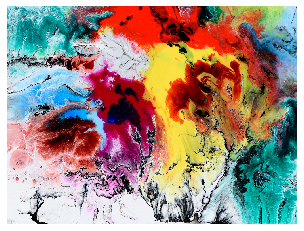

In [9]:
plt.imshow(Image.open(os.path.join('data','style_1.jpg')))
plt.axis('off')

In [10]:
tf.reset_default_graph()
sess = tf.InteractiveSession(
    config=tf.ConfigProto(allow_soft_placement=True)
)

def image_gen_func(data_dir, file_match_str, do_shuffle=True):
    
    #This function returns a processed image and the color channel mean values.
   # This is a generator function used by the tf.data api.
    
    
    # Loading filenames
    files = [f for f in os.listdir(data_dir) if f.startswith(file_match_str)]
    if do_shuffle:
        shuffle(files)
    
    mean = np.array([[vgg_mean]])
    
    # For each file preprocess the images and yield
    for f in files:
        img = Image.open(os.path.join(data_dir, f))
        
        width, height = img.size
        
        # We crop the image to a square by cropping on the longer axis
        if width < height:
            left,right = 0, width
            top, bottom = (height-width)/2, ((height-width)/2) + width
        elif width > height:
            top, bottom = 0, height
            left, right = (width - height)/2, ((width-height)/2) + height
        else:
            arr = np.array(img.resize((image_size,image_size))).astype(np.float32)
            yield (arr, mean)
        
        arr = np.array(img.crop((left, top, right, bottom)).resize((image_size,image_size))).astype(np.float32)
        yield (arr, mean)
    

def load_images_iterator(gen_func, zero_mean=False):
   
    #This function returns a dataset iterator of tf.data API

    image_dataset = tf.data.Dataset.from_generator(
        gen_func, 
        output_types=(tf.float32, tf.float32), 
        output_shapes=(tf.TensorShape(input_shape[1:]), tf.TensorShape([1, 1, 3]))
    )
    
    # If true, the mean will be subtracted
    if zero_mean:
        image_dataset = image_dataset.map(lambda x,y: (x - y, y))
    
    # We get on image at a time in a single batch
    image_dataset = image_dataset.batch(1)
    # Defining the iterator
    iterator = image_dataset.make_one_shot_iterator()
    return iterator

# Defining partial functions to used by the tf.data.Dataset.from_generator()
part_style_gen_func = partial(image_gen_func, 'data', "style_")
part_content_gen_func = partial(image_gen_func, 'data', "content_")

style_iter = load_images_iterator(part_style_gen_func, zero_mean=False)
content_iter = load_images_iterator(part_content_gen_func, zero_mean=False)

NameError: name 'input_shape' is not defined

In [11]:
next_style_image = style_iter.get_next()
next_content_image = content_iter.get_next()

plt.subplot(1,2,1)
plt.imshow(sess.run(next_style_image)[0][0]/255.0)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sess.run(next_content_image)[0][0]/255.0)
plt.axis('off')

sess.close()

NameError: name 'style_iter' is not defined

In [12]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.InteractiveSession(config=config)

# 1. Defining the input pipeline
part_style_gen_func = partial(image_gen_func, 'data', "style_")
part_content_gen_func = partial(image_gen_func, 'data', "content_")

style_iter = load_images_iterator(part_style_gen_func, zero_mean=True)
content_iter = load_images_iterator(part_content_gen_func, zero_mean=True)

# 2. Defining the inputs and weights
inputs = define_inputs(input_shape)
define_tf_weights()

layer_ids = list(vgg_layers.keys())

# gen_ph is used to initialize the generated image with the pixel values 
# of the content image. You are welcome to try initializing with white noise
# or the style image. The init_generated gives the initialization operation
gen_ph = tf.placeholder(shape=input_shape, dtype=tf.float32)
init_generated = tf.assign(inputs["generated"], gen_ph)

# 3. Losses
# 3.1 Content loss
c_loss = define_content_loss(
    inputs=inputs, 
    layer_ids=layer_ids, pool_inds=pool_inds, c_weight=alpha
)

# 3.2 Style loss
layer_weights_ph = tf.placeholder(shape=[len(layer_ids)], dtype=tf.float32, name='layer_weights')
s_loss = define_style_loss(
    inputs=inputs, 
    layer_ids=layer_ids, pool_inds=pool_inds, s_weight=beta, layer_weights=None
)

# 3.3 Total loss
tot_loss = c_loss + s_loss

# 4. Optimizer
optimize = define_optimize(tot_loss)

//anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


NameError: name 'input_shape' is not defined

In [13]:
def save_image_with_restore(image, img_mean, save_path):
   # This function saves an image to disk 
    
    image_restored = image + img_mean
    image_restored = np.clip(image_restored,0,255.0)
    image_restored = image_restored.astype('uint8')
    Image.fromarray(image_restored).save(save_path)
    
    
def get_layer_weights(type_id, num_layers):
    
   # This function returns different layer weight schemes
   # to be experimented with. 
    
    
    if type_id == 0:
        weights = np.arange(1,num_layers+1)**1.5
        weights = weights/np.sum(weights)
    if type_id == 1:
        weights = np.arange(1,num_layers+1)**1.5
        weights = weights/np.sum(weights)
        weights = weights[::-1]
        
    return weights

In [14]:
del vgg_layers # Releasing memory

n_iter = 500 # Number of optimizations steps per image


for j in range(10):
    print('\nProcessing the {}th image ...'.format(j+1))
    tf.global_variables_initializer().run()
    (cont, cont_mean), (style, style_mean) = sess.run([content_iter.get_next(), style_iter.get_next()])
    
    # Saving the content and style images to disk
    if not os.path.exists(os.path.join('data','gen_{}'.format(j))):
        os.mkdir(os.path.join('data', 'gen_{}'.format(j)))
    save_image_with_restore(cont[0], cont_mean[0], os.path.join('data', 'gen_{}'.format(j),'content.jpg'))
    save_image_with_restore(style[0], style_mean[0], os.path.join('data', 'gen_{}'.format(j),'style.jpg'))
    
    # Initialize the generated image with the values of the content image
    sess.run(init_generated, feed_dict={gen_ph:cont})
    for i in range(n_iter):

        l, _ = sess.run([tot_loss,optimize], feed_dict={
            inputs["content"]: cont,
            inputs["style"]: style,
            layer_weights_ph: get_layer_weights(0, len(layer_ids))
        })

        # Printing out results and saving the generated image
        if (i+1)%50==0:
            print('\tLoss at iteration {}: {}'.format(i+1, l))
            gen_image = sess.run(inputs["generated"])
            save_image_with_restore(gen_image[0], cont_mean[0], os.path.join('data', 'gen_{}'.format(j),'gen_{}.jpg'.format(i+1)))

NameError: name 'vgg_layers' is not defined

In [15]:
#https://github.com/thushv89/exercises_thushv_dot_com/blob/master/neural_style_transfer_light_on_math_ml/neural_style_transfer.ipynb